整理自 链接：  https://hrl.boyuai.com/chapter/2/ppo%E7%AE%97%E6%B3%95

&&  https://gymnasium.farama.org/tutorials/training_agents/reinforce_invpend_gym_v26/

Gymnasium 测试环境链接： https://gymnasium.farama.org/environments/classic_control/pendulum/

* pip install gymnasium[classic-control]



伪码 参考自： https://spinningup.openai.com/en/latest/algorithms/ppo.html

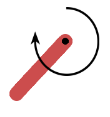

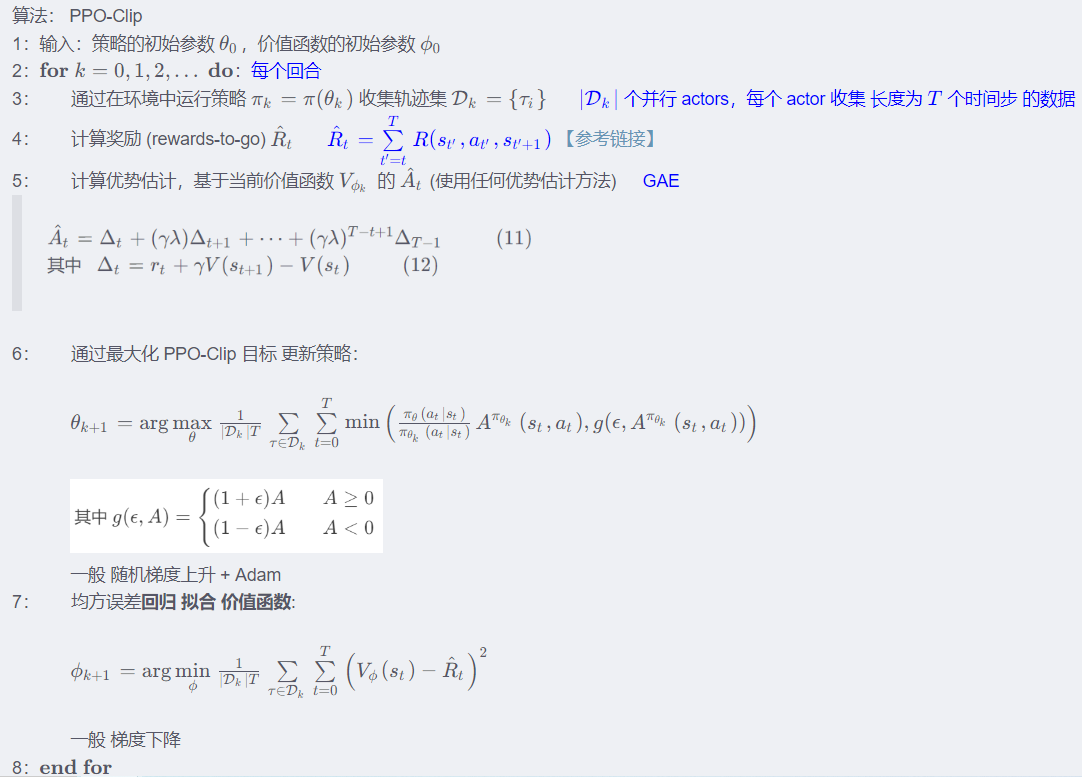

# Code


* https://github.com/boyu-ai/Hands-on-RL/blob/main/rl_utils.py

In [8]:
!pip install gymnasium

In [9]:
import gymnasium as gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

import warnings   # 忽略警告
warnings.filterwarnings("ignore")

## 代码模块

### 策略 的 神经网络 (actor)

策略网络输出连续动作高斯分布（Gaussian distribution）的均值和标准差。后续的连续动作则在该高斯分布中采样得到。

In [10]:
class PolicyNetContinuous(torch.nn.Module):
  def __init__(self, state_dim, hidden_dim, action_dim):
    super().__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
    self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
    self.fc_std = torch.nn.Linear(hidden_dim, action_dim)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    mu = 2.0 * torch.tanh(self.fc_mu(x))  # 2.0 是在干啥？
    std = F.softplus(self.fc_std(x))
    return mu, std

https://docs.python.org/zh-cn/3/library/functions.html#super

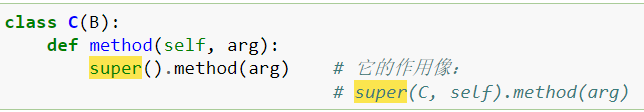

### 价值函数  的 神经网络 (critic)

In [11]:
class ValueNet(torch.nn.Module):
  def __init__(self, state_dim, hidden_dim):
    super().__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
    self.fc2 = torch.nn.Linear(hidden_dim, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    return self.fc2(x)

### —— 优势函数 估计  (GAE )

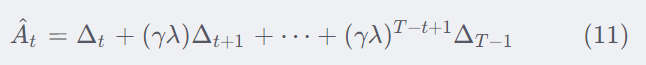

In [12]:
# 优势函数 估计   https://github.com/boyu-ai/Hands-on-RL/blob/main/rl_utils.py

def computer_advantage(γ, λ, Δts):  # TD 误差
  Δts = Δts.detach().numpy() # 提高计算速度
  advantage_list = []
  advantage = 0.0
  for delta in Δts[::-1]:  # T-1, ...,
    advantage = γ * λ * advantage + delta
    advantage_list.append(advantage)
  advantage_list.reverse()
  return torch.tensor(advantage_list,dtype=torch.float)

每个 $~ \hat A_t~$ 从 $~t~$ 开始计算到 最后一个时间步  $~T-1$

$\Delta_{ts}=[\Delta_t, ~~\Delta_{t+1},~~\Delta_{t+2}]$

依次遍历 $[\Delta_{t+2},~~\Delta_{t+1},~~\Delta_t]$

>循环 1：  $\Delta_{t+2}$

>* advantage = $γλ ·0 + \Delta_{t+2}$

>*  advantage_list = $[\Delta_{t+2}]$

> 循环 2： $\Delta_{t+1}$


>* advantage = $γλ ·\Delta_{t+2}+\Delta_{t+1}$

>* advantage_list = $[\Delta_{t+2}, ~~γλ ·\Delta_{t+2}+\Delta_{t+1}]$


> 循环 3： $\Delta_t$


>* advantage = $γλ ·(γλ ·\Delta_{t+2}+\Delta_{t+1})+\Delta_t$

>* advantage_list = $[\Delta_{t+2}, ~~γλ ·\Delta_{t+2}+\Delta_{t+1}, ~~\Delta_t+γλ\Delta_{t+1}+(γλ)^2\Delta_{t+2}]$

循环结束， 逆序   advantage_list = $[\Delta_t+γλ\Delta_{t+1}+(γλ)^2\Delta_{t+2},~~\Delta_{t+1}+γλ ·\Delta_{t+2}, ~~\Delta_{t+2}]$




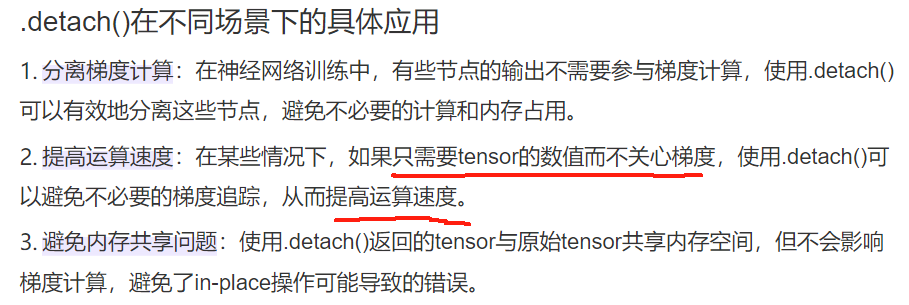

### PPO-Clip 算法 (agent)

In [13]:
class PPOContinuous:
  """ 处理连续动作的 PPO-Clip """
  def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, λ,epochs, eps, γ, device):
    self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim).to(device)
    self.critic = ValueNet(state_dim, hidden_dim).to(device)
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),lr=actor_lr)
    self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)

    self.γ = γ
    self.λ = λ  # lambda
    self.epochs = epochs # N
    self.eps = eps  # epsilon  ε  让概率比 r 在 [1-ε,1+ε]
    self.device = device

  def sample_action(self, state):
    state = torch.tensor([state], dtype=torch.float).to(self.device)
    mu, sigma = self.actor(state)
    action = torch.distributions.Normal(mu, sigma).sample()
    return [action.item()]

  def update(self, transition_dict):  # 传入采集的数据，更新网络参数
    states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
    actions = torch.tensor(transition_dict['actions']).view(-1,1).to(self.device)
    rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1,1).to(self.device)
    next_states = torch.tensor(transition_dict['next_states'],dtype=torch.float).to(self.device)
    dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1,1).to(self.device)

    # 对奖励进行修改， 方便训练
    rewards = (rewards + 8.0) / 8.0

    # 计算
    # Δt = r_t + γ V(s_{t+1}) - V(s_t)
    # Δts =[Δt, Δt+1, Δt+2,..., ΔT-1]
    td_target = rewards + self.γ * self.critic(next_states) * (1-dones)  # critic 也要用。 R = r + γ V (s_{t+1}) ???
    Δts = td_target - self.critic(states)
    advantage = computer_advantage(self.γ, self.λ,Δts.cpu()).to(self.device)  # 张量 GPU 数组 CPU 要在一个地方才能计算

    mu, std = self.actor(states)
    action_dists = torch.distributions.Normal(mu.detach(), std.detach())  # 用估计的 均值 和标准差 构建正态分布
    old_log_probs = action_dists.log_prob(actions)

    for _ in range(self.epochs):  # 同样的数据， 让神经网络见 10 次，等效于 并行 actors ???
      mu, std = self.actor(states)
      action_dists = torch.distributions.Normal(mu, std)
      log_probs = action_dists.log_prob(actions)

      ratio = torch.exp(log_probs - old_log_probs)  # exp (log - log) 不能直接除吗？
      actor_loss = torch.mean( -torch.min(ratio * advantage, torch.clamp(ratio, 1-self.eps, 1 + self.eps) * advantage)) # 若是简化版本，还要判断 A 的正负

      critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))  # V(s_t) - R

      # 更新 神经网络的权重
      self.actor_optimizer.zero_grad()
      self.critic_optimizer.zero_grad()
      actor_loss.backward()
      critic_loss.backward()
      self.actor_optimizer.step()
      self.critic_optimizer.step()

## 训练

In [21]:
actor_lr = 1e-4
critic_lr = 5e-3
num_episodes = 5000
hidden_dim = 128
gamma = 0.9
lmbda = 0.9
epochs = 3   # 当一个完整的数据集通过了神经网络一次并且返回了一次,这个过程称为一次 epoch。  这是论文里说的 并行 N 个 actors ？？？
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]  # 连续动作空间
agent = PPOContinuous(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,
            epochs, eps, gamma, device)


def train_on_policy_agent(env, agent, num_episodes):
    return_list = []
    for i in range(10):
        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes/10)):
                episode_return = 0
                transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
                state = env.reset(seed=0)[0]
                done = False
                while not done:
                    action = agent.sample_action(state)
                    next_state, reward, terminated, truncated, info = env.step(action)
                    done = terminated or truncated  ## 一定要记得这里
                    transition_dict['states'].append(state)
                    transition_dict['actions'].append(action)
                    transition_dict['next_states'].append(next_state)
                    transition_dict['rewards'].append(reward)
                    transition_dict['dones'].append(done)
                    state = next_state
                    episode_return += reward
                return_list.append(episode_return)
                agent.update(transition_dict)
                if (i_episode+1) % 10 == 0:
                    pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
    return return_list


return_list = train_on_policy_agent(env, agent, num_episodes)

# Pendulum-v1 奖励 -16 - 0
# https://gymnasium.farama.org/environments/classic_control/pendulum/

Iteration 9: 100%|██████████| 500/500 [00:58<00:00,  8.61it/s, episode=5000, return=-538.342]


## 可视化

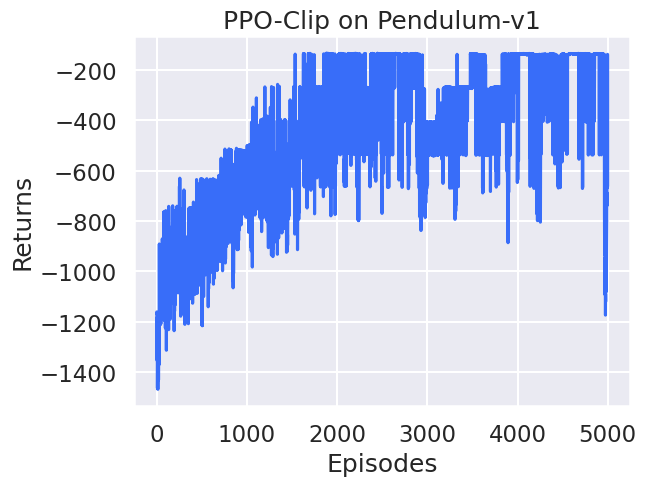

In [29]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO-Clip on {}'.format(env_name))
plt.show()

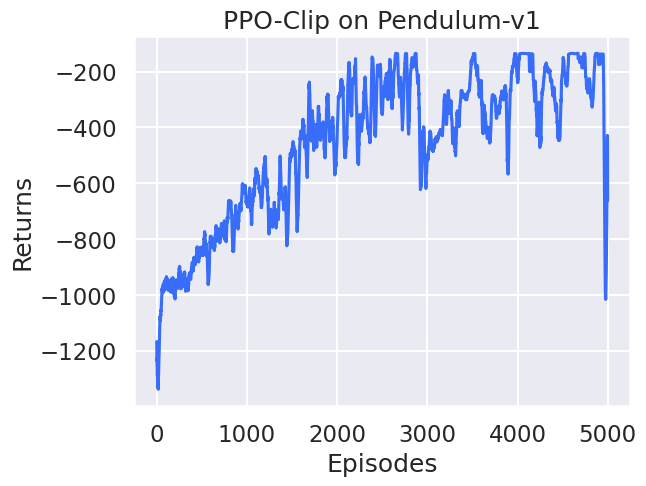

In [30]:
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

mv_return = moving_average(return_list, 21)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO-Clip on {}'.format(env_name))
plt.show()

### seed 实验

In [24]:
# Create and wrap the environment
env_name = "Pendulum-v1"
env = gym.make(env_name)
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # Records episode-reward
# # deque_size – The size of the buffers return_queue and length_queue  本代码中 打印的回报均值 为 50 个回合的均值

actor_lr = 1e-4
critic_lr = 5e-3
num_episodes = 5000
hidden_dim = 128
gamma = 0.9
lmbda = 0.9
epochs = 3   # 当一个完整的数据集通过了神经网络一次并且返回了一次,这个过程称为一次 epoch。  这是论文里说的 并行 N 个 actors ？？？
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]  # 连续动作空间
rewards_over_seeds = []

for seed in [42, 2024, 10]:  # seeds
    # set seed
    torch.manual_seed(seed)
    # random.seed(seed)
    np.random.seed(seed)

    # Reinitialize agent every seed
    agent = PPOContinuous(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,
            epochs, eps, gamma, device)
    reward_over_episodes = []

    for episode in range(num_episodes):
        # gymnasium v26 requires users to set seed while resetting the environment
        obs, info = wrapped_env.reset(seed=seed)
        transition_dict = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': []
            }

        done = False
        while not done:
            action = agent.sample_action(obs)
            next_obs, reward, terminated, truncated, info = wrapped_env.step(action)
            done = terminated or truncated
            transition_dict['states'].append(obs)
            transition_dict['actions'].append(action)
            transition_dict['next_states'].append(next_obs)
            transition_dict['rewards'].append(reward)
            transition_dict['dones'].append(done)
            obs = next_obs

        reward_over_episodes.append(wrapped_env.return_queue[-1])
        agent.update(transition_dict)

        if episode % 1000 == 0:
            avg_reward = int(np.mean(wrapped_env.return_queue))
            print("Episode:", episode, "Average Reward:", avg_reward)

    rewards_over_seeds.append(reward_over_episodes)

# Pendulum-v1 奖励 -16 - 0
# https://gymnasium.farama.org/environments/classic_control/pendulum/

Episode: 0 Average Reward: -1190
Episode: 1000 Average Reward: -808
Episode: 2000 Average Reward: -710
Episode: 3000 Average Reward: -526
Episode: 4000 Average Reward: -476
Episode: 0 Average Reward: -293
Episode: 1000 Average Reward: -687
Episode: 2000 Average Reward: -482
Episode: 3000 Average Reward: -268
Episode: 4000 Average Reward: -170
Episode: 0 Average Reward: -352
Episode: 1000 Average Reward: -1495
Episode: 2000 Average Reward: -1493
Episode: 3000 Average Reward: -1493
Episode: 4000 Average Reward: -1493


[Text(0.5, 1.0, 'PPO-Clip for Pendulum-v1')]

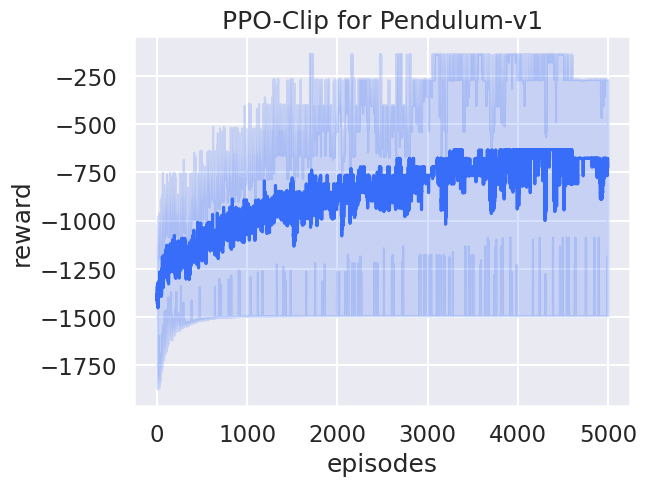

In [27]:
import pandas as pd
import seaborn as sns

rewards_to_plot = [[reward[0] for reward in rewards] for rewards in rewards_over_seeds]

df1 = pd.DataFrame(rewards_to_plot).melt()
df1.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df1).set(
    title="PPO-Clip for {}".format(env_name)
)

[Text(0.5, 1.0, 'PPO-Clip for Pendulum-v1')]

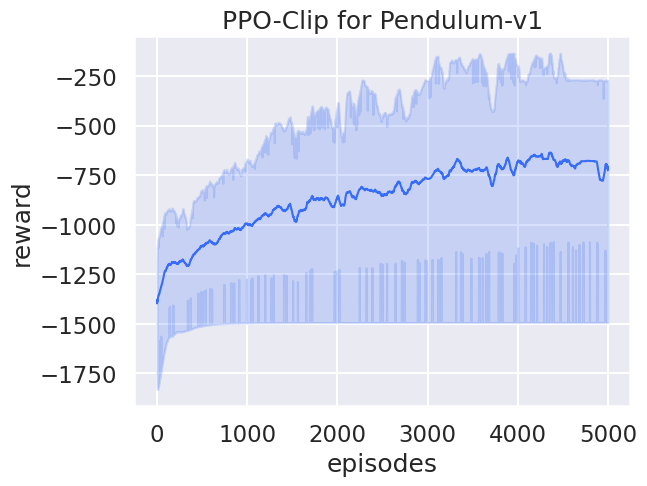

In [28]:
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

rewards_to_plot = [[reward[0] for reward in rewards] for rewards in rewards_over_seeds]
# print(rewards_to_plot)
for i in range(len(rewards_to_plot)):
  rewards_to_plot[i] = moving_average(rewards_to_plot[i], 69) # 调这里 更改平滑度

# rewards_to_plot = [[reward[0] for reward in np.array(moving_average(rewards, window_size=29))] for rewards in rewards_over_seeds]
df1 = pd.DataFrame(rewards_to_plot).melt()  #  .rolling(window=30).mean()

df1.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df1, linewidth=1.5).set(
    title="PPO-Clip for {}".format(env_name)
)   # 调线宽